<img src="http://www.leadtraining.com.mt/excel-courses/images/time-series-forecaster.png" alt="Drawing" align="right" style="width: 100px;"/>
# Time series analysis with Python (*by Hrant Davtyan*)
<br/>

Time series analysis (also known as forecasting) comprises methods for analyzing time series data (data that includes the "time" variable). <br/>
There are several issues regarding the time series data that one needs to consider before moving to analytics:
- **Trend** - Persistent upward or downward pattern in data (can exists due to consumer behavior, population, economy, technology changes etc.)
- **Seasonality** - Regular up and down movements in data *[less than 1 year]* (can be the consequence of customs, weather or festival etc.)
- **Cyclicity** - Repeating up and down movements *[usually 2-10 years]* because of e.g. macroeconomic factors such as recession
- **Irregularity** - Irregular and unexpected random variation or unforeseen events in data (also known as whit noise)

Based on the above described points, we can roughly present our prediction as a function of those 4 components: **`Y = f(T, S, C, I)`** <br/>
The functional relationship of our prediction (Y) with the 4 components in general can be one of the 2 types:
- **Additive** - `Y = T + S + C + I`, which basically shows that the 4 components are independent,
- **Multiplicative** - `Y = T x S x C x I`, which basically shows that one of the components depends on the other.

There a re many different tyoes of models used for time series analysis, and the model selection depends on the type of the functional relationship described above (additive or multiplicative). However, there is one thing which is common to (almost) any model/method that one may apply (inddifferent from the type of functional relationship): [**stationarity**](https://en.wikipedia.org/wiki/Stationary_process). The time series data is ready for modelling/analytics if and only if it is stationary (as it is the main assumption lyeing behind most of the models). This means that any non-stationary data must be converted to stationary before applying any model/method to it. So what is this stationarity and why is it so important?

From the intuitive point of view, stationarity data is the one with no trend and seasonality. This is the reason that when converting the non-stationary data to a stationary the two main steps are **de-trending** and **de-seasonization**. <br/>
From the statistical point of view, stationarity is the property of time series data, for which all *important* parameters are constant over time (e.g. mean, variance, autocorrelation etc).

This notebook describes the main (starting) methods for time series analysis using the famous [AirPasseners dataset](https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv). The latter provides monthly data on international airline passengers (in thousands) for the period of [1949,1961). In order to find the best curve which fits our dataset, we will overgo the following steps:

1. [Understand stationarity (Trend and Seasonality) based on visualization](#section1)
2. [Apply MA and EWMA techniques to fit a curve to our still non-stationary data](#section2)
3. [Apply MA and EWMA techniques to fit a curve to already detrended data (after substracting average)](#section3)
4. [Apply MA and EWMA techniques to fit a curve to already detrended data (after calculating one period difference)](#section4)
5. [Apply MA and EWMA techniques to fit a curve to alread detrended data, after getting rid of the correlation between trend and seasonality (using logarithmic transformation)](#section5)

The first things to do are to import the libraries necessary for performing the above mentioned tasks and to read the dataset in this notebook.

In [2]:
# importing necessary libraries
import pandas as pd # to present the data and apply MA technique
import numpy as np # to later perform mathematical transformation
import matplotlib.pyplot as plt # make plots
# to present plots inline with the code (on the same page)
%matplotlib inline

In [3]:
# reading the csv file from "Downloads" folder of my computer
data = pd.read_csv(r'C:\Users\Legion\Downloads\AirPassengers.csv')
# showing the first 5 observations of the dataset
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


As you can see from the DataFrame above, we have two columns: "Month", which presents the time series, and "Passengers", which presents the number of international passengers (in thousands) who travelled in that month. It is important to tell Python explicitly that "Month" is the column with time series data. Also, we can get rid of the very first column which provides the enumerations of DataFrame rows. To implement the latter and also to initialize "Month" as the time series component, we will import the same data again, but with several more parameters in the `read_csv` function.

In [4]:
# reading the data again with telling pandas to parse dates from the column "Month"
# and to make the column "Month" the index column (the very first one in Bold)
data = pd.read_csv(r'C:\Users\Legion\Downloads\AirPassengers.csv',parse_dates=['Month'], index_col='Month')
# showing the first 5 observations of the data
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


As you can see now, we got read of the very first column with row enumeration and now, the "Month" column is the very first, index column. As it is the index column, and also because it provides the time series component in the data, we can use it to select some observations as provided below.

In [5]:
# show all observations in 1949 (must be 12 observations - one per each month)
data['1949']

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


If you are interested in only several observations in a year or in several years (e.g. only summer, 1949) that is again doable in an easy manner, as described below.

In [6]:
# observations in summer, 1949, i.e. 06, 07 and 08 months of 1949
data['1949-06':'1949-08']

,Passengers
Month,
1949-06-01,135
1949-07-01,148
1949-08-01,148


<a id='section1'></a>
### *1. Checking stationarity*

Let's now plot the data and otherstand visually, whether there is a Trend/Seasonality or not.

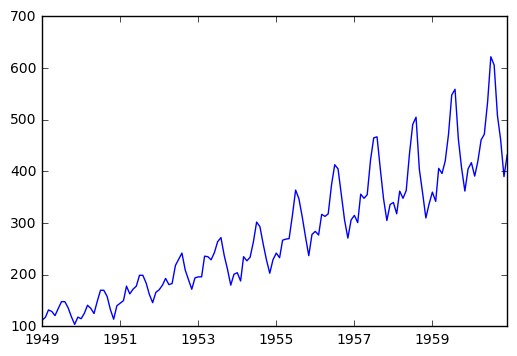

In [7]:
plt.plot(data)

From the plot above it is clearly visible that there is a quite significant positive (increasing) trend in the data. The repeating fluctiations above suggest that we have either Seasonality or Cyclisity in the dataset. Based on the facts that thoe fluctuations are happening on annual basis (so not more than a year) and that they are quite regular (expected), we conclude that Seasonality is the source of fluctuations (and not Cyclicity). Usually, rigorous statistical tests are used for determining the stationairty of the data (e.g. [Dickey-Fuller test](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)) as the graph alone may not convey enough information for decision-making. But for now we are satified with visualization only. <br/>
Another important conclusion that we can make from the plot above is that Trend and Seasonality **are not independent**: the fluctuations are becoming stronger/more volatile as the trend is increasing. Thus, we can conclude that for now, **multiplicative** models are more appropriate for our dataset. <br/>
Let's bear in mind the conclusion above, we will apply them in future. But for now, let's apply probably the simpliest and one of the most populat forecating technique called [**Moving Average (MA)**](https://en.wikipedia.org/wiki/Moving_average).This technique is also known as Rolling Mean, and it simply calculates the mean (arichmetic average) over a given period of time (e.g. average for a year, for a month, for a week etc) to fit the curve to the data and, in the end, make predictions. As our data on passengers is a monthly data, we will use annual averages (12-month average) for fitting purpose, as described below.

<a id='section2'></a>
### *2. Applying MA and EWMA*

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  from ipykernel import kernelapp as app


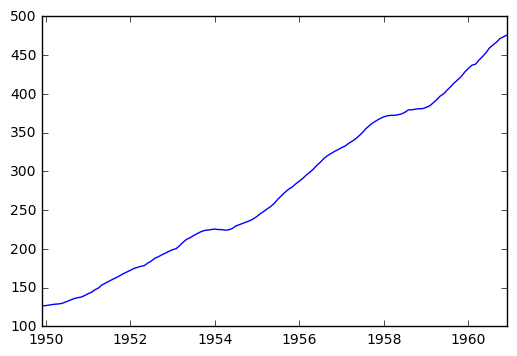

In [8]:
# use rolling_mean method from Pandas library to calculate MA(12), i.e. Moving average for each year
rolmean = pd.rolling_mean(data, window=12)
# plot the results
plt.plot(rolmean)

The plot above alone, is not quite informative, so let's plot it on our actualt data to make comparison easier

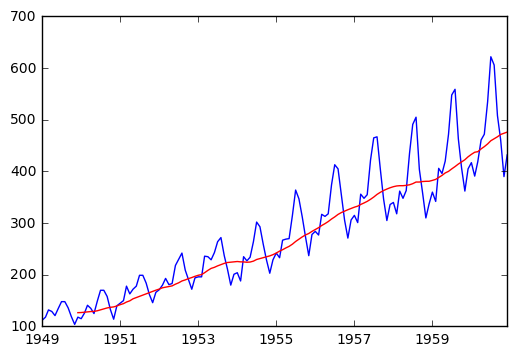

In [9]:
# plot original data in blue
orig = plt.plot(data, color='blue',label='Original')
# plot MA(12) fitted curve in read
mean = plt.plot(rolmean, color='red', label='Rolling Mean')

From the plot above we can infer that in average, our fitted line does a good job of describing the increasing trend. Yet, it fails when it comes predicting seasonal fluctuations. Let's now try to calculate and plot the Exponentially weighted moving average (more popular as [**Exponential Smoothing**](https://en.wikipedia.org/wiki/Exponential_smoothing)) on actual/original data and see wther it is doing better. The pandas function used for that purpose is ***`pd.ewma`***.

## (2nd part /Tuesday lecture/ starts here)

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
  from ipykernel import kernelapp as app


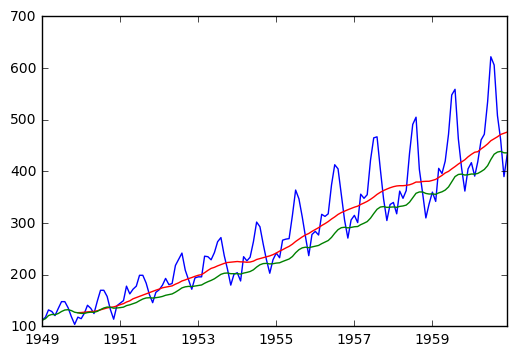

In [10]:
# use ewma method from Pandas library to calculate exponentially weighted MA(12) [from now on EWMA(12)]
exp_smooth = pd.ewma(data, halflife=12)
# plot original data in blue
plt.plot(data, color='blue')
# plot MA(12) fitted curve in red
plt.plot(rolmean, color='red')
# plot EWMA(12) fitted curve in green
plt.plot(exp_smooth, color='green')

As can be seen from the graph above, the EWMA fitted curve (green) is lower than the MA fitted curve (red), hence, providing worse results. As for the MA (red) curve, also it provides better fitting, it still underestimates the Trend. Generally, MA always underestimates whenever there is an increaseing trend, and overestimates in the decreasing trend case.

### *3. Substructing average*
<a id='section3'></a>

In the begining of this document, it was stated that different Time Series Analysis techniques should be applied once the data is stationarized. In this part of the project, we will try to de-trend the data wby starting the averages from the actual dataset.

In [11]:
# create new DataFrame, which presents the difference between actual data and rolling mean values
data_diff = data - rolmean
# view the first 12 observations in the new DataFrame
data_diff.head(12)

,Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


The table above shows, that we have missing values for the first 11 observations in the *new* dataset. This missing values are generated, because moving average was estimated using window=12 parameter, which calculates an average of each 12 months. This means there is no average for first 11 motnths, thus there is no difference of actual data and average. For simlicity, we will drop those missing values from the dataset. Fortunately, dropping missing values, is also very easy if you use Pandas.

In [12]:
# using dropna method from Pandas, to drop missing values
# the argument inplace=True tells Pandas to drop those values from our dataset without creating a new one
data_diff.dropna(inplace=True)
# view the first 12 observations to ensure missing values were dropped
data_diff.head(12)

,Passengers
Month,
1949-12-01,-8.666667
1950-01-01,-11.916667
1950-02-01,-1.583333
1950-03-01,12.666667
1950-04-01,6.166667
1950-05-01,-4.166667
1950-06-01,18.666667
1950-07-01,37.833333
1950-08-01,36.000000


Now, once we have a new dataset (hopefully de-trended), we can apply both techniques (MA and EWMA) again and observe the results.

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,com=12).mean()


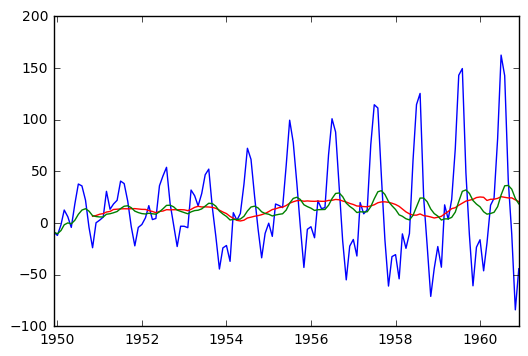

In [13]:
# estimating MA for the new dataset
ma_diff = pd.rolling_mean(data_diff,12)
# estimating EWMA for the new dataset
exp_diff = pd.ewma(data_diff,12)
# plotting our new dataset
plt.plot(data_diff)
# plotting MA 
plt.plot(ma_diff, color='red')
# plotting EWMA
plt.plot(exp_diff,color='green')

The graph above shows that our new dataset (blue) still has significant seasonality, yet we were able to get rid of the trend using substraction technique. Both MA and EWMA estimates are quite horizontal, which means our dataset is ***mean stationary*** (the mean is independent of time). We can also observe (small) seasonality in EWMA estimate (the ups and downs of the green curve).

One may conclude, that also both MA and EWMA techniques did not have great fit on the actual data, MA can be quite handy for de-trending reasons and EWMA already does a good job of (somewhat) predicting the seasonality.

It is also important to mention, that seasonal fluctuations are increasing over time. The latter will be dealt in part 5.

<a id='section4'></a>
### *4. Differencing using lagged values*

The above described method of substraction is fine, yet not always efficient. It may not always capture the trend as MA may underestimate or overestimate it. Moreover, that method requires you to run MA beforehand, which can be computationally extensive. This part introduces another approach to de-trending. Again we will crete a new DataFrame based on the original data we have, but this time we will substract from our data its lagged values. More specifically, for any given time period **t**, we will calculate **Value(t) - Value(t-1)**. As a consequence, the new dataset will have a missing value for the first observation (as there is no preceeding time period for the first observation).

This taks can be accomplished using shift() method (again) from Pandas.

In [14]:
# creating new dataset based on the difference between actual and lagged values
data_lagged = data - data.shift()
# view the first 5 observations of the data
data_lagged.head()

,Passengers
Month,
1949-01-01,NaN
1949-02-01,6.0
1949-03-01,14.0
1949-04-01,-3.0
1949-05-01,-8.0


Now, once we have a new dataset (hopefully de-trended), we can apply both techniques (MA and EWMA) again and observe the results.

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,com=12).mean()


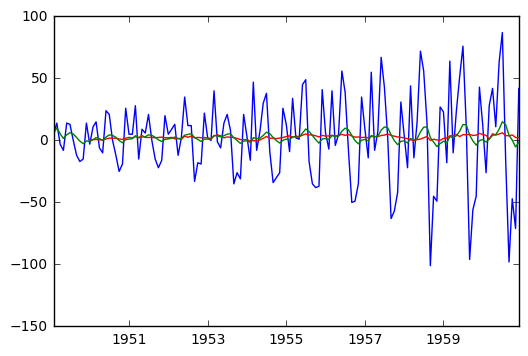

In [18]:
# estimating MA for the new dataset
ma_lagged = pd.rolling_mean(data_lagged,12)
# estimating EWMA for the new dataset
exp_lagged = pd.ewma(data_lagged,12)
# plotting our new dataset
plt.plot(data_lagged)
# plotting MA 
plt.plot(ma_lagged,color='red')
# plotting EWMA
plt.plot(exp_lagged,color='green')

The graph above shows no trend, and the MA curve (red) is **more horizontal** than in the substraction case in part 3. This result is consistent with the above provided claim, that substraction technique may not fully capture the trend.

<a id='section5'></a>
### 5. Logarithmic transformation

The techniques discussed in part 3 and 4 deal with Trend problem. Yet, the increasing fluctutations in seasonal component still remain, which are the consequence of correlation between Trend and Seasonality. In this part of the project, we will try to neutralize this effect using <a href='https://en.wikipedia.org/wiki/Data_transformation_(statistics)'>logarithmic transformation</a> technique.

Logarithmic transformation is a monotone transformation, meaning that the original order of values is preserved (bigger values are still greater after transformation). It helps to capture the relative change as opposed to absolute difference. In our case, the correlation between Trend and Seasonality assumes Multiplicative functional relationship. This suggests that conversion to Additive functional relationship may neutralize the correlation. The latter can be succesfully accomplished by log-transformation (using the natural logarithm).

In [19]:
# use log() function from numpy library to calculate the natural logarithm
log_data = np.log(data)

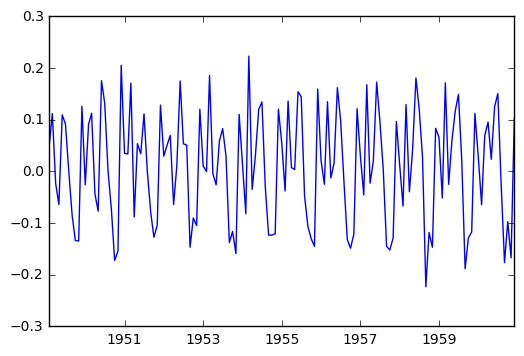

In [20]:
# use differencing technique from part 3 to get de-trend the dataset
log_data_lagged = log_data - log_data.shift()
# plot the new, de-trended, transformed dataset
plt.plot(log_data_lagged)

The above graph is the *most mature* among all having been produced after solving both Trend and Trend-Seasonality correlation problems. The latter (absence of correlation) can be visually observed, as the seasonal fluctuations do not increase or decrease as time goes by. We can now fit the MA and EWMA models to this final dataset.

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  from ipykernel import kernelapp as app
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,min_periods=0,adjust=True,com=12).mean()


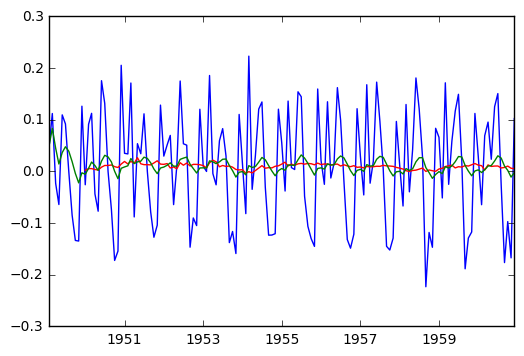

In [21]:
# estimating MA(12)
ma_lagged_log = pd.rolling_mean(log_data_lagged,12)
# estimating EWMA(12)
exp_lagged_log = pd.ewma(log_data_lagged,12)
# plotting our new log-transformed and de-trended dataset
plt.plot(log_data_lagged)
# plotting MA curve
plt.plot(ma_lagged_log,color='red')
# plotting EWMA curve
plt.plot(exp_lagged_log,color='green')

The models and techniques described above can be tuned by manually changing one or several parameters which were for now used only with given default values. Following the objectives of this course, we will not tune them. Instead, next lectures on Operations Analytics will be spend on learning new techniques, such as ARIMA, SVM Regression, PCA, Regression with Decision Trees and/or Aritficial Neural Networks (2 of those mentioned models are expected to be covered, but you may seard in Google for a documentation/description on the rest).